In [164]:
rm(list=ls())

library(DoubleML)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(repr)
library(data.table)
library(mvtnorm)
suppressMessages(library(parallel))
suppressMessages(library(ggplot2))
suppressMessages(library(doMC))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

In [165]:
# Default DGP only 
generate_DGP <- function(n_obs,dim_x,theta,s,seed) {
    
    set.seed(seed)
    # multiplicatives in nuisance functions  
    a_1 = 0.25
    b_1 = 0.25
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # Toeplitz covariance matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    x       <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat) 
    
    # nuisance parameter m_0 and propensity function d  
    #m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    b     <- c(rep(1/8,8), rep(0,dim_x-8))
    m_0_x <- (1/2*pi)*((sinh(1))/(cosh(1)- cos(x %*% b))) 
    d     <- as.matrix(m_0_x + eps)
    
    # nuisance paraneter g_0 and outcome y
    g_0_x <- exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3]
    y     <- as.matrix(theta*d + g_0_x + ups)

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
} 

In [166]:
# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  
    m_hat <- learner$clone()
    
    DML_PLR1  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=4)   
    DML_PLR1$fit()                                            
    theta_1 <- DML_PLR1$coef
    
    DML_PLR3  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=5)   
    DML_PLR3$fit()                                            
    theta_3 <- DML_PLR3$coef
        
    DML_PLR7  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=10)   
    DML_PLR7$fit()                                            
    theta_7 <- DML_PLR7$coef

    theta_estims    <- cbind(theta_1,theta_3,theta_7)
    return(theta_estims)
}

In [167]:
# Simulation function: Take in generate_data, spit out estimates for theta coef and sd
sim_function <- function(data){
    
    DML_data    <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    coef_output <- est_lasso(DML_data) 
    return(coef_output)
}

In [168]:
### Fixed Design Parameters
n_rep  = 100
n_vars = 150
theta  = 1
s      = 0

# Varied k and sample size
sample_size <- seq(30, 300, by = 10)

In [169]:
iterations = vector("list",length(sample_size))

for (i in 1:length(sample_size)) {
    
    boot_fx <- function(iteration) {        
        data        <- generate_DGP(theta=theta,n_obs=sample_size[i],dim_x=n_vars,seed=iteration)
        theta_estim <- sim_function(data) 
        return(theta_estim) 
    }
    
    parallel_estims <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    iterations[[i]] <- do.call(rbind, parallel_estims)

}

In [186]:
bias_matrix <- matrix(NA, ncol = 3, nrow = length(sample_size))
var_matrix <- matrix(NA, ncol = 3, nrow = length(sample_size))
mse_matrix <- matrix(NA, ncol = 3, nrow = length(sample_size))

mse <- function(x){   
    return (mean((x - theta)^2)) 
}

for (i in 1:length(sample_size)) {
    bias_matrix[i,] <- abs(colMeans(iterations[[i]]) - 1)
    var_matrix[i,]  <- apply(iterations[[i]], 2, var)
    mse_matrix[i,]  <- apply(iterations[[i]], 2, mse) 
}

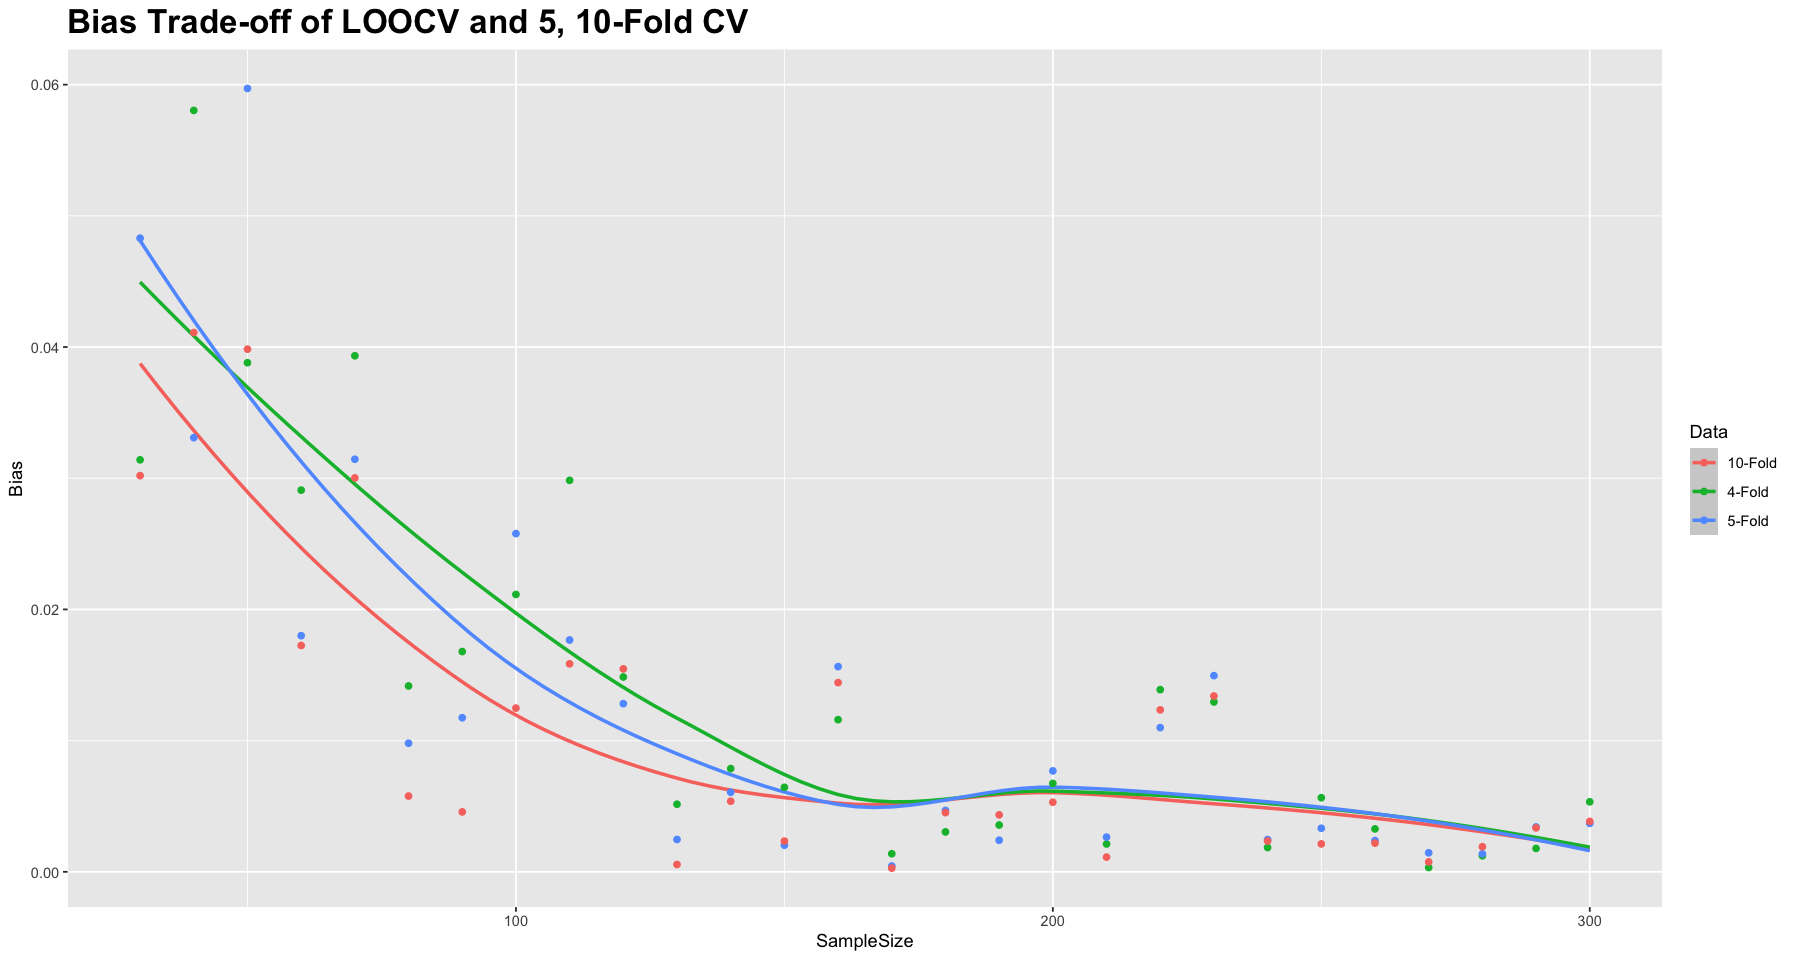

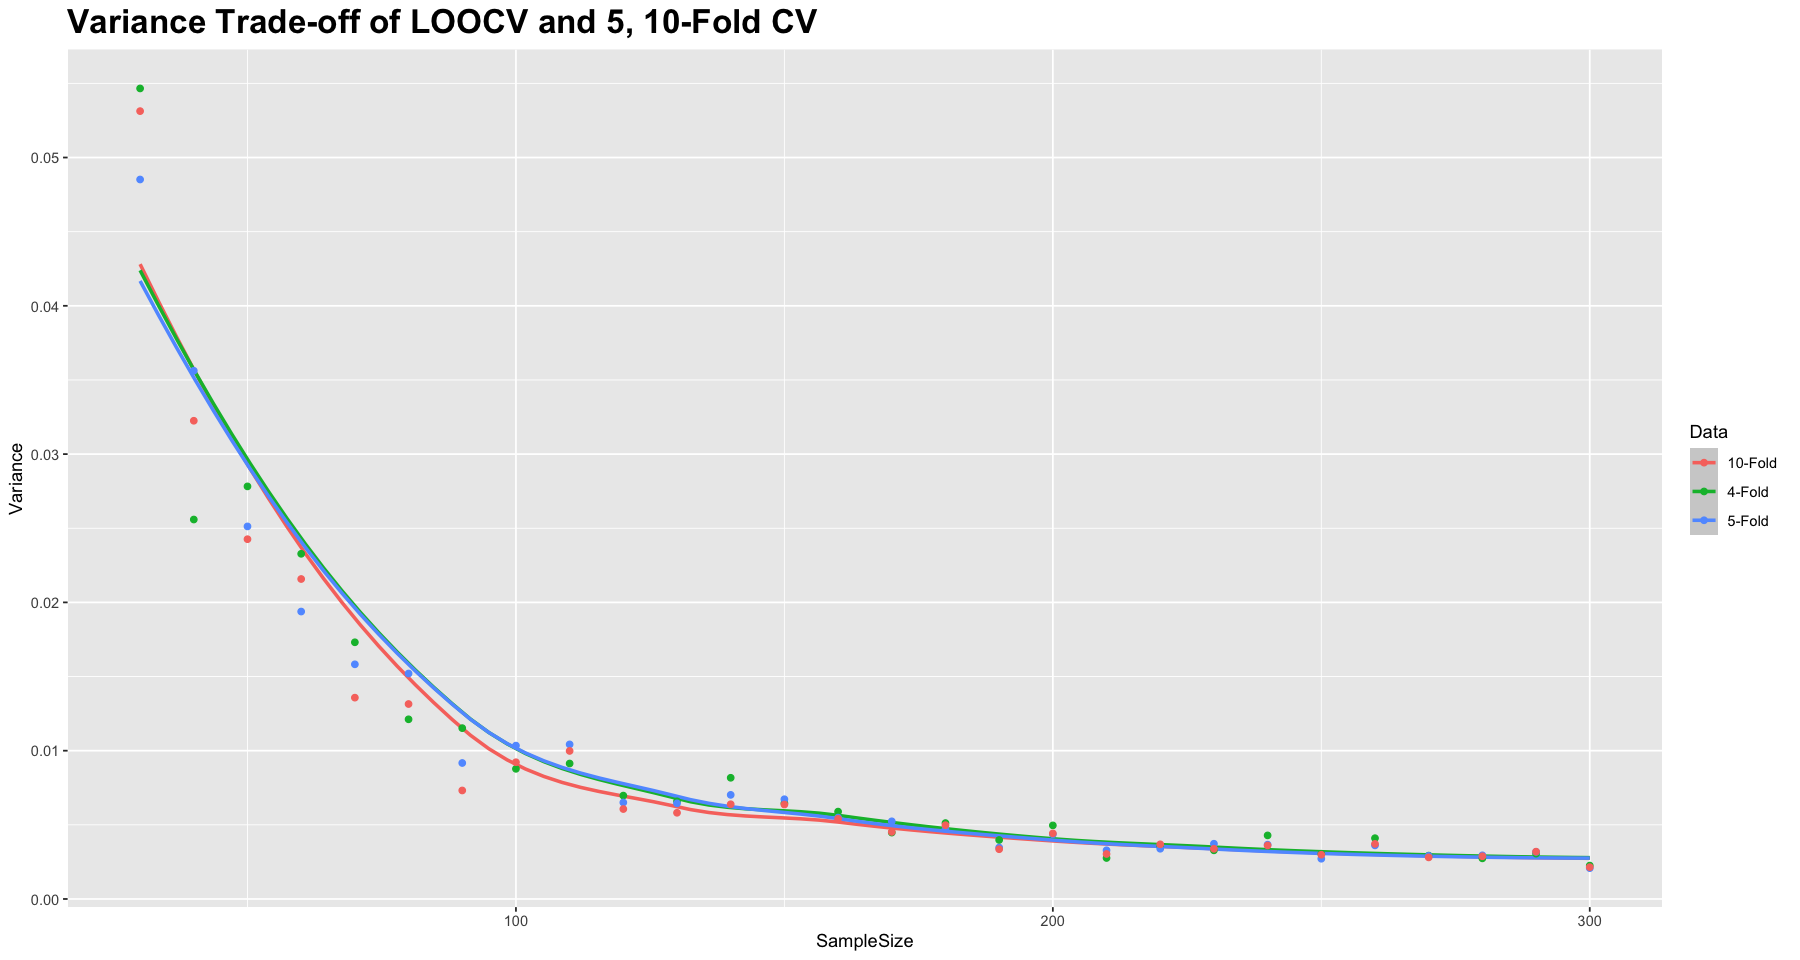

In [191]:
# All the result are organized in a trade-off matrix which will be used to plot graphs
df_tradeoff <- data.frame(c(rep("4-Fold",length(sample_size)),
                            rep("5-Fold",length(sample_size)),
                            rep("10-Fold",length(sample_size))),
    c(bias_matrix[,1],bias_matrix[,2],bias_matrix[,3]),
    c(var_matrix[,1],var_matrix[,2],var_matrix[,3]),
    c(mse_matrix[,1],mse_matrix[,2],mse_matrix[,3]),
    rep(sample_size,3))
colnames(df_tradeoff)<-c("Data","Bias","Variance","MSE", "SampleSize")

# Plot the Bias against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=Bias, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("Bias Trade-off of LOOCV and 5, 10-Fold CV") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Variance against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=Variance, group=Data, colour=Data)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0, 0.05), xlim=c(0, 300)) +
    ggtitle("Variance Trade-off of LOOCV and 5, 10-Fold CV") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)


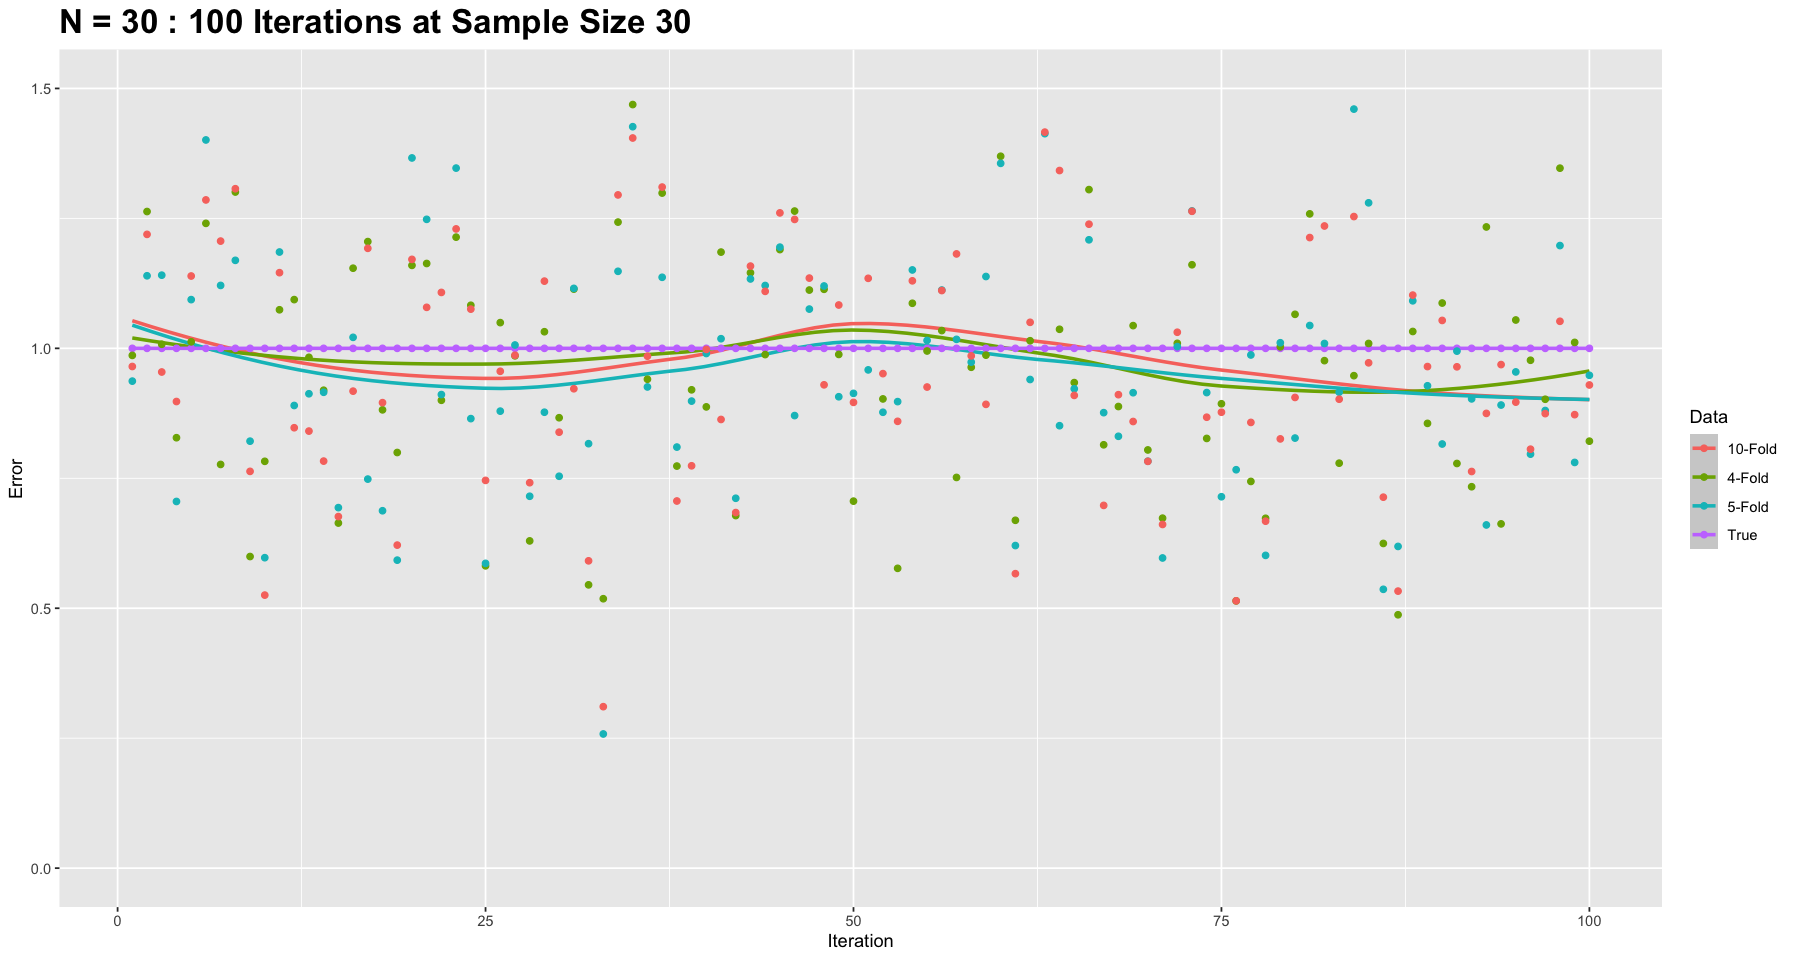

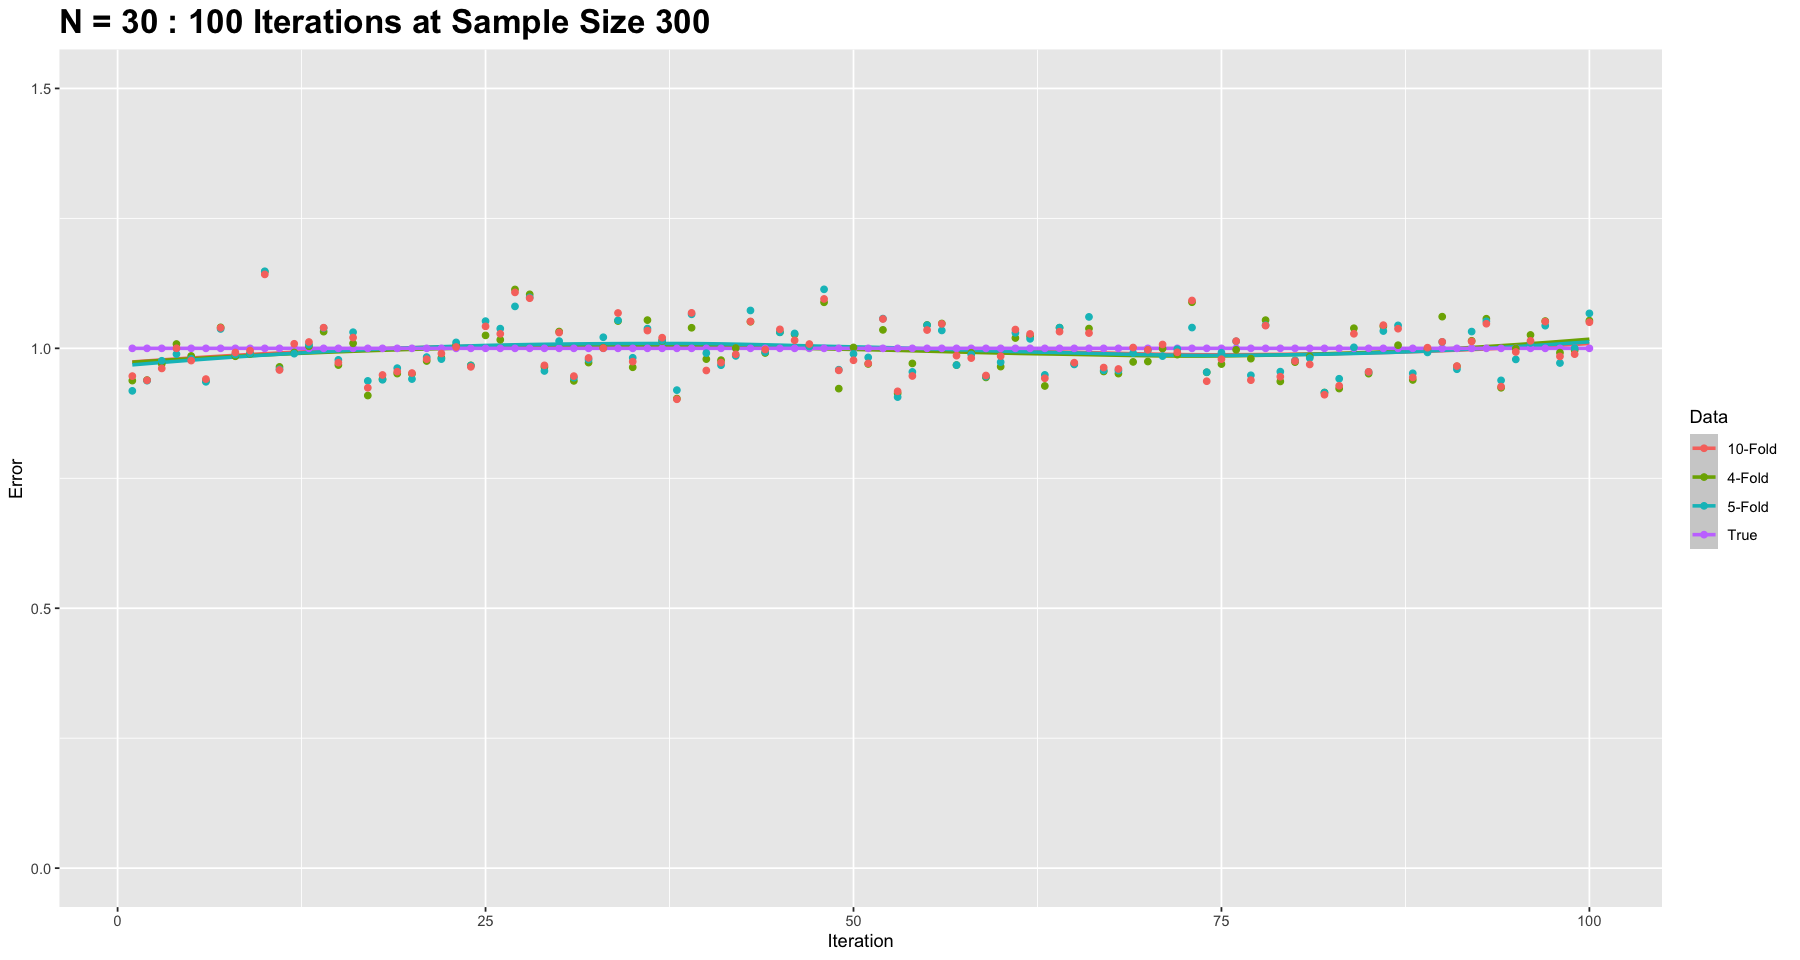

In [194]:
i = 1
df_errors <- data.frame(c(rep("True",n_rep),rep("4-Fold",n_rep), rep("5-Fold",n_rep), rep("10-Fold",n_rep)),
    rep(1:n_rep,4),c(rep(theta,n_rep),matrix(iterations[[i]],n_rep,3)[,1],matrix(iterations[[i]],n_rep,3)[,2],matrix(iterations[[i]],n_rep,3)[,3]))
colnames(df_errors)<-c("Data","Iteration","Error")

# Plot the Errors when N = 500
ggplot(data=df_errors, aes(x=Iteration, y=Error, group=Data, colour=Data)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    geom_point() + 
    coord_cartesian(ylim=c(0,1.5)) +
    ggtitle("N = 30 : 100 Iterations at Sample Size 30 ") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

i = 28
df_errors <- data.frame(c(rep("True",n_rep),rep("4-Fold",n_rep), rep("5-Fold",n_rep), rep("10-Fold",n_rep)),
    rep(1:n_rep,4),c(rep(theta,n_rep),matrix(iterations[[i]],n_rep,3)[,1],matrix(iterations[[i]],n_rep,3)[,2],matrix(iterations[[i]],n_rep,3)[,3]))
colnames(df_errors)<-c("Data","Iteration","Error")

# Plot the Errors when N = 500
ggplot(data=df_errors, aes(x=Iteration, y=Error, group=Data, colour=Data)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    geom_point() + 
    coord_cartesian(ylim=c(0,1.5)) +
    ggtitle("N = 30 : 100 Iterations at Sample Size 300") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)